# Decipher'ing Caesar with Transformer

## Get the data

In [1]:
import requests

url = "https://raw.githubusercontent.com/Pythonista7/dataset_simple_ciphers/refs/heads/main/cipher_decipher_dataset.json"
response = requests.get(url)

if response.status_code == 200:
    with open("cipher_decipher_dataset.jsonl", "wb") as f:
        f.write(response.content)
    print("File downloaded successfully as cipher_decipher_dataset.jsonl")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully as cipher_decipher_dataset.jsonl


In [2]:
import pandas as pd

In [3]:
data = pd.read_json("cipher_decipher_dataset.jsonl", lines=True)
data.head()

,original_text,ciphered_text,offset
0,"Furthermore , as an encouragement to revisioni...","Jyvxlivqsvi , ew er irgsyvekiqirx xs vizmwmsrm...",4
1,The Unitarian clergy were an exclusive club of...,Hvs Ibwhofwob qzsfum ksfs ob slqzigwjs qzip ct...,14
2,"Ezra Stiles Gannett , an honorable representat...","Ytlu Mncfym Auhhynn , uh bihiluvfy lyjlymyhnun...",20
3,"Even so , Gannett judiciously argued , the Ass...","Jajs xt , Lfssjyy ozinhntzxqd fwlzji , ymj Fxx...",5
4,We today are not entitled to excoriate honest ...,Fn cxmjh jan wxc nwcrcunm cx nglxarjcn qxwnbc ...,9


In [4]:
test_str = data['original_text'].iloc[121]
test_str

"He often spoke of them as his `` ecumenical '' glasses and used them as a symbol of the kind of vision that is required in the church ."

First let us build up the learning task conceptually and then build the transformer.

## Learning Objective

Given a cipher string and the offset as input, we expect the model to decode the string correct back into readable plain text. This sounds simple but the variable offset is what is going to be tricky for the model to learn. 

To start off , lets define a vocab and come up with a prepresentation for the problem.

### Making things simpler

First thing we'll do is clean up the data and re-hash it to make our life easy. We will only keep alnum's and remove everything else from the string and rehash it using the offset, we will also lowercase all text. Just these 2 things will bring down the vocab size significantly. 

In [5]:
import re
import matplotlib.pyplot as plt

In [6]:
def filter_for_alnum(s: str):
    return re.sub(r'[^a-zA-Z0-9 ]', '', s)

In [7]:
print(f"test_str before filtering: {test_str} +10")
print(f"test_str after filtering: {filter_for_alnum(test_str+'10')}")

test_str before filtering: He often spoke of them as his `` ecumenical '' glasses and used them as a symbol of the kind of vision that is required in the church . +10
test_str after filtering: He often spoke of them as his  ecumenical  glasses and used them as a symbol of the kind of vision that is required in the church 10


In [8]:
def generate_cipher(c: str, k: int) -> str:
    if 'A' <= c <= 'Z':
        return chr((ord(c) - ord('A') + k) % 26 + ord('A'))
    if 'a' <= c <= 'z':
        return chr((ord(c) - ord('a') + k) % 26 + ord('a'))
    return c

In [9]:
print("Before Cipher: ", test_str)
print(f"After Filtering: {filter_for_alnum(test_str+'10')}")
print("After Cipher: ", ''.join([generate_cipher(s, 1) for s in filter_for_alnum(test_str)]))

Before Cipher:  He often spoke of them as his `` ecumenical '' glasses and used them as a symbol of the kind of vision that is required in the church .
After Filtering: He often spoke of them as his  ecumenical  glasses and used them as a symbol of the kind of vision that is required in the church 10
After Cipher:  If pgufo tqplf pg uifn bt ijt  fdvnfojdbm  hmbttft boe vtfe uifn bt b tzncpm pg uif ljoe pg wjtjpo uibu jt sfrvjsfe jo uif divsdi 


Offsets distribution:


<Axes: xlabel='offset'>

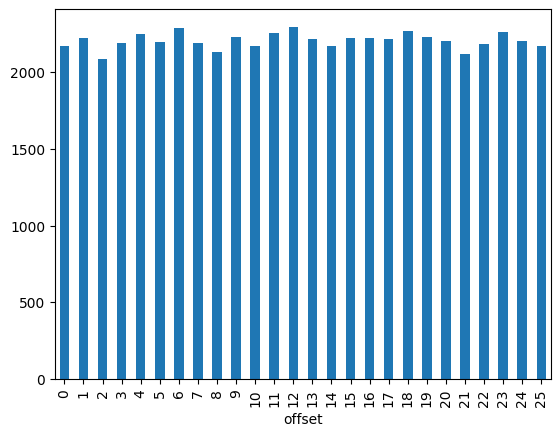

In [10]:
clean_data = data.copy()
clean_data['filtered_text'] = clean_data['original_text'].apply(filter_for_alnum).apply(lambda x: x.lower())
clean_data['ciphered_text'] = clean_data.apply(
    lambda row: ''.join([generate_cipher(c, int(row['offset'])) for c in row['filtered_text']]),
    axis=1
)
clean_data.dropna(subset=['filtered_text', 'ciphered_text'], inplace=True)
print("Offsets distribution:")
# plot offset counts
offset_dist = clean_data['offset'].value_counts().sort_index()
offset_dist.plot(kind="bar")

In [11]:
clean_data.drop(columns=['original_text'], inplace=True)
clean_data.to_csv("cleaned_cipher_data.csv", index=False)
print("Cleaned data saved to cleaned_cipher_data.csv")

Cleaned data saved to cleaned_cipher_data.csv


In [12]:
clean_data = pd.read_csv("cleaned_cipher_data.csv")
clean_data.head()

,ciphered_text,offset,filtered_text
0,jyvxlivqsvi ew er irgsyvekiqirx xs vizmwmsrmw...,4,furthermore as an encouragement to revisionis...
1,hvs ibwhofwob qzsfum ksfs ob slqzigwjs qzip ct...,14,the unitarian clergy were an exclusive club of...
2,ytlu mncfym auhhynn uh bihiluvfy lyjlymyhnunc...,20,ezra stiles gannett an honorable representati...
3,jajs xt lfssjyy ozinhntzxqd fwlzji ymj fxxth...,5,even so gannett judiciously argued the assoc...
4,fn cxmjh jan wxc nwcrcunm cx nglxarjcn qxwnbc ...,9,we today are not entitled to excoriate honest ...


In [13]:
# sanity checks

# check for nans
has_nans = clean_data.isna().sum()
print("NaN values in each column:\n", has_nans)
if has_nans["ciphered_text"] > 0 or has_nans["filtered_text"] > 0:
    print("!!! WARNING !!!\nData contains NaN values. Dropping rows with NaN values.")
    clean_data = clean_data.dropna(subset=['filtered_text', 'ciphered_text'])



NaN values in each column:
 ciphered_text    168
offset             0
filtered_text    168
dtype: int64
!!! WARNING !!!
Data contains NaN values. Dropping rows with NaN values.


### Some dataset stats

Max offset in ciphered_text: 25
Max length of filtered_text: 1013


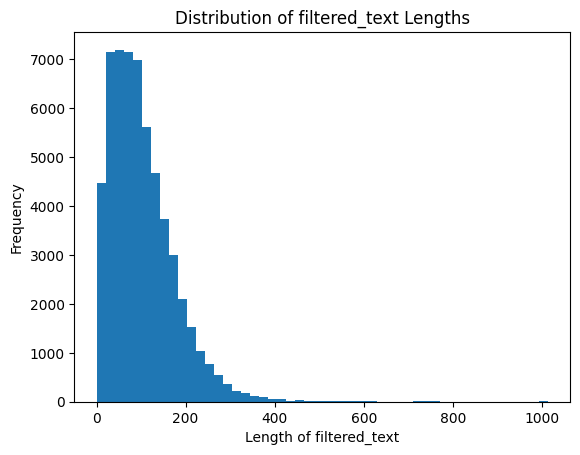

In [14]:
print("Max offset in ciphered_text:", clean_data['offset'].max())
print("Max length of filtered_text:", clean_data['filtered_text'].str.len().max())
# print("Length distribution of filtered_text:")
plt.hist(clean_data['filtered_text'].str.len(), bins=50)
plt.xlabel('Length of filtered_text')
plt.ylabel('Frequency')
plt.title('Distribution of filtered_text Lengths')
plt.show()

Great now that we have clean data, lets get started with defining learning objectives.

### What should be learnt?

This is the interesting question here, we want the model to look at the whole of `ciphered_text` and the `offset` , then be able to predict the `filtered_text`. The only way the model can do this is by paying attention to the "offset". There are a bunch of different decisions to make:
- How do we want to handle variable length string? (Hint: `<PAD>` but then be mindful of calculating loss) 
- How should offset be represented? Should it be included in th token space or its own embedding representation ?
- Do we use signaling tokens like `<BOS>` , `<EOS>` , how does that impact our learning performance? How we do present the src,tgt_in and tgt_out when using these?

# Experiment 1: Simple String and Offset in token space

Lets start off with simple transformer model with encoder and decoder which has the the offset indicated by a special token type `<O=1>` ,`<O=2>`....`<O=25>` because we have a max offset of 25 in our training data.

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


# set default device to mps if available 
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Using device: {device}")



Using device: mps


## Vocab Setup

In [16]:
VOCAB_1 = ['<PAD>', '<BOS>', '<EOS>'] + list("abcdefghijklmnopqrstuvwxyz0123456789 ") + [f"<O={i}>" for i in range(0, 26)]
vocab_size_1 = len(VOCAB_1)
char2idx_1 = {c: i for i, c in enumerate(VOCAB_1)}
idx2char_1 = {i: c for i, c in enumerate(VOCAB_1)}

CONTEXT_SIZE = 128 # Looking at the distribution plot, we can set context size to 128 to cover most samples and avoid unnecessary padding. Will try 256 later as well.

print("Vocab Size:", vocab_size_1)
print("VOCAB_1:", VOCAB_1)

Vocab Size: 66
VOCAB_1: ['<PAD>', '<BOS>', '<EOS>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '<O=0>', '<O=1>', '<O=2>', '<O=3>', '<O=4>', '<O=5>', '<O=6>', '<O=7>', '<O=8>', '<O=9>', '<O=10>', '<O=11>', '<O=12>', '<O=13>', '<O=14>', '<O=15>', '<O=16>', '<O=17>', '<O=18>', '<O=19>', '<O=20>', '<O=21>', '<O=22>', '<O=23>', '<O=24>', '<O=25>']


## Build Dataset


In [17]:
class CipherDatasetV1(Dataset):
    def __init__(self, dataframe: pd.DataFrame, char2idx: dict, max_length: int = 256, padding: bool = True):
        self.dataframe = dataframe
        self.char2idx = char2idx
        self.max_length = max_length
        self.padding = padding

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        input_text = row['ciphered_text']
        target_text = row['filtered_text']
        offset = row['offset']

        input_ids = [self.char2idx['<BOS>']] + [self.char2idx[c] for c in input_text][:self.max_length - 2] + [self.char2idx['<EOS>']]
        target_in_ids = [self.char2idx['<BOS>']] + [self.char2idx[c] for c in target_text][:self.max_length - 2] + [self.char2idx['<EOS>']]
        target_out_ids = target_in_ids[1:] + [self.char2idx['<PAD>']]

        if self.padding:
            input_ids += [self.char2idx['<PAD>']] * (self.max_length - len(input_ids))
            target_in_ids += [self.char2idx['<PAD>']] * (self.max_length - len(target_in_ids))
            target_out_ids += [self.char2idx['<PAD>']] * (self.max_length - len(target_out_ids))

        return {
            'input_ids': input_ids,
            'target_in_ids': target_in_ids,
            'target_out_ids': target_out_ids,
            'offset': offset
        }

In [18]:
dataset_1 = CipherDatasetV1(clean_data, char2idx_1, max_length=CONTEXT_SIZE, padding=True)

sample = dataset_1[1]
decoded_input = [idx2char_1[i] for i in sample["input_ids"]]
decoded_target_in = [idx2char_1[i] for i in sample["target_in_ids"]]
decoded_target_out = [idx2char_1[i] for i in sample["target_out_ids"]]
offset = sample['offset']
print("Src Input IDs:", len(sample['input_ids']))
print(''.join(decoded_input))
print("Target In IDs:", len(sample['target_in_ids']))
print(''.join(decoded_target_in))
print("Target Out IDs:", len(sample['target_out_ids']))
print(''.join(decoded_target_out))
print('Offset = ',offset)

Src Input IDs: 128
<BOS>hvs ibwhofwob qzsfum ksfs ob slqzigwjs qzip ct qizhwjohsr usbhzsasb  og hvs hsfa kog hvsb ibrsfghccr wb hvs poqy pom  obr dofy<EOS>
Target In IDs: 128
<BOS>the unitarian clergy were an exclusive club of cultivated gentlemen  as the term was then understood in the back bay  and park<EOS>
Target Out IDs: 128
the unitarian clergy were an exclusive club of cultivated gentlemen  as the term was then understood in the back bay  and park<EOS><PAD>
Offset =  14


In [19]:
# Dataloader
def collate_fn(batch):
    src_ids = [item['input_ids'] for item in batch]
    tgt_in_ids = [item['target_in_ids'] for item in batch]
    tgt_out_ids = [item['target_out_ids'] for item in batch]
    offset = [item['offset'] for item in batch]
    return {
        'input_ids': torch.tensor(src_ids, dtype=torch.long),
        'target_in_ids': torch.tensor(tgt_in_ids, dtype=torch.long),
        'target_out_ids': torch.tensor(tgt_out_ids, dtype=torch.long),
        'offset': torch.tensor(offset,dtype=torch.int)
    }

In [20]:
# dataloader_1 = DataLoader(dataset_1, batch_size=64, shuffle=True, collate_fn=collate_fn)

### Create Train/Validation Split

In [21]:
from sklearn.model_selection import train_test_split


In [22]:

# Split data into train and validation sets (80/20 split)
train_data, val_data = train_test_split(clean_data, test_size=0.2, random_state=42, stratify=clean_data['offset'])

print(f"Total samples: {len(clean_data)}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"\nOffset distribution in training set:")
print(train_data['offset'].value_counts().sort_index())
print(f"\nOffset distribution in validation set:")
print(val_data['offset'].value_counts().sort_index())

Total samples: 57172
Training samples: 45737
Validation samples: 11435

Offset distribution in training set:
offset
0     1727
1     1769
2     1668
3     1748
4     1790
5     1750
6     1820
7     1749
8     1701
9     1777
10    1733
11    1798
12    1827
13    1770
14    1734
15    1775
16    1774
17    1763
18    1808
19    1778
20    1758
21    1687
22    1739
23    1806
24    1758
25    1730
Name: count, dtype: int64

Offset distribution in validation set:
offset
0     431
1     442
2     417
3     437
4     448
5     437
6     455
7     437
8     425
9     444
10    433
11    450
12    457
13    443
14    434
15    444
16    444
17    441
18    452
19    445
20    440
21    421
22    435
23    452
24    439
25    432
Name: count, dtype: int64


In [23]:
# Create separate datasets for train and validation
train_dataset = CipherDatasetV1(train_data.reset_index(drop=True), char2idx_1, max_length=CONTEXT_SIZE, padding=True)
val_dataset = CipherDatasetV1(val_data.reset_index(drop=True), char2idx_1, max_length=CONTEXT_SIZE, padding=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 715
Validation batches: 179


In [24]:
# Also create a tiny dataloader for quick testing which samples across all offsets
def create_tiny_dataloader(dataset, batch_size=32, subset_size=None):
    # Group indices by offset
    offset_groups = {}
    for idx in range(len(dataset)):
        offset = dataset.dataframe.iloc[idx]['offset']
        if offset not in offset_groups:
            offset_groups[offset] = []
        offset_groups[offset].append(idx)

    # Sample from each offset group
    sampled_indices = []
    if subset_size is None:
        # Default behavior: use batch_size to determine subset size
        samples_per_group = batch_size // len(offset_groups)
    else:
        # Use specified subset_size
        samples_per_group = subset_size // len(offset_groups)
    
    for offset, indices in offset_groups.items():
        sampled_indices.extend(indices[:samples_per_group])  # Sample evenly from each group

    # Create a subset of the dataset with the sampled indices
    tiny_subset = torch.utils.data.Subset(dataset, sampled_indices)
    return tiny_subset, DataLoader(tiny_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [25]:
tiny_ds,tiny_loader = create_tiny_dataloader(dataset_1, batch_size=32,subset_size=320)
for batch in tiny_loader:
    print("Tiny batch input_ids shape:", batch['input_ids'].shape)
    print("Tiny batch target_in_ids shape:", batch['target_in_ids'].shape)
    print("Tiny batch target_out_ids shape:", batch['target_out_ids'].shape)
    print("Tiny batch offset shape:", batch['offset'].shape)
    break

Tiny batch input_ids shape: torch.Size([32, 128])
Tiny batch target_in_ids shape: torch.Size([32, 128])
Tiny batch target_out_ids shape: torch.Size([32, 128])
Tiny batch offset shape: torch.Size([32])


# Model a Transformer

In my previous naive transformer implementation with only autograd i learnt a bunch from just using the primitives but now its time to learn the tool of torch well so we will be using optimized building blocks which torch provides like `torch.nested` and `scaled_dot_product_attention` and `torch.compile` which will massively speed things up for training.

Would highly recommend reading [this blog from pytorch](https://docs.pytorch.org/tutorials/intermediate/transformer_building_blocks.html). But a quick summary and take away is:
> MHA implementation of torch is now optimized with nice quirks of jagged-tensors and scaled_attn which skip the need for padding. Note that we are now using a 2 new flags when defining atten layers : `need_weights = bool` and `average_attn_weights=bool` these must internally dictate if torch is going to use the fused SDPA kernal or it it step by step. So we will move these levers up a layer so we can use optimized ver for training and viz during inference.

## Core model

In [26]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout), # same dropout for both attn and ff to simplify tuning, can separate later if needed
            nn.Linear(d_ff, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None, return_attn=False):
        attn_out, attn_w = self.self_attn(
            x, x, x,
            key_padding_mask=src_key_padding_mask,
            need_weights=return_attn,
            average_attn_weights=False,
        )
        x = self.norm1(x + self.drop(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.drop(ff_out))
        return x, (attn_w if return_attn else None)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn  = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, return_attn=False):
        # masked self-attn
        self_out, self_w = self.self_attn(
            x, x, x,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=return_attn,
            average_attn_weights=False,
        )
        x = self.norm1(x + self.drop(self_out))

        # cross-attn
        cross_out, cross_w = self.cross_attn(
            x, memory, memory,
            key_padding_mask=memory_key_padding_mask,
            need_weights=return_attn,
            average_attn_weights=False,
        )
        x = self.norm2(x + self.drop(cross_out))

        ff_out = self.ff(x)
        x = self.norm3(x + self.drop(ff_out))
        return x, (self_w if return_attn else None), (cross_w if return_attn else None)

def causal_mask(T, device):
    # True means "mask out" for MultiheadAttention when using bool mask
    return torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)

In [27]:
class Seq2SeqCipherTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4, d_ff=1024, pad_id=0, max_len=CONTEXT_SIZE):
        super().__init__()
        self.pad_id = pad_id
        self.d_model = d_model

        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.offset_emb = nn.Embedding(26, d_model)

        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, nhead, d_ff) for _ in range(num_layers)])
        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, nhead, d_ff) for _ in range(num_layers)])

        self.out = nn.Linear(d_model, vocab_size)

    def embed(self, ids, offset: int, include_offset_in_emb=False):
        B, T = ids.shape
        pos = torch.arange(T, device=ids.device).unsqueeze(0).expand(B, T)
        res = self.tok_emb(ids) * (self.d_model ** 0.5) + self.pos_emb(pos)
        if include_offset_in_emb and offset is not None:
            # offset shape: [B] -> [B, 1, d_model] to broadcast across time
            offset_idx = offset.long().clamp(min=0, max=25)
            offset_vec = self.offset_emb(offset_idx).unsqueeze(1)
            res = res + offset_vec
        return res

    def forward(self, src_ids, tgt_in_ids, offset, return_attn=False):
        B, Tsrc = src_ids.shape
        _, Ttgt = tgt_in_ids.shape

        src_kpm = (src_ids == self.pad_id)      # True where PAD
        tgt_kpm = (tgt_in_ids == self.pad_id)   # True where PAD
        tgt_mask = causal_mask(Ttgt, src_ids.device)

        src = self.embed(src_ids, offset, include_offset_in_emb=True)
        tgt = self.embed(tgt_in_ids, offset, include_offset_in_emb=True) # I care about deciphering conditioned on offset, not discovering offset. This can be trained separately later if needed.

        attn = {"enc_self": [], "dec_self": [], "dec_cross": []} if return_attn else None

        memory = src
        for layer in self.enc_layers:
            memory, w = layer(memory, src_key_padding_mask=src_kpm, return_attn=return_attn)
            if return_attn: attn["enc_self"].append(w)   # [B, H, Tsrc, Tsrc]

        x = tgt
        for layer in self.dec_layers:
            x, ws, wc = layer(
                x, memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_kpm,
                memory_key_padding_mask=src_kpm,
                return_attn=return_attn
            )
            if return_attn:
                attn["dec_self"].append(ws)    # [B, H, Ttgt, Ttgt]
                attn["dec_cross"].append(wc)   # [B, H, Ttgt, Tsrc]

        logits = self.out(x)  # [B, Ttgt, vocab]
        return logits, attn

## Attention Viz helper

In [28]:
class AttnVizUtils:
    def __init__(self, vocab, pad_token="<PAD>", bos_token="<BOS>", eos_token="<EOS>"):
        self.vocab = vocab
        self.pad_token = pad_token
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.char2idx = {c: i for i, c in enumerate(vocab)}
        self.idx2char = {i: c for i, c in enumerate(vocab)}
        self.pad_id = self.char2idx.get(pad_token, None)

    def encode_text(self, text, add_bos=True, add_eos=True):
        ids = []
        if add_bos:
            ids.append(self.char2idx[self.bos_token])
        ids.extend([self.char2idx[c] for c in text])
        if add_eos:
            ids.append(self.char2idx[self.eos_token])
        return ids

    def decode_ids(self, ids, stop_at_eos=True):
        if isinstance(ids, torch.Tensor):
            ids = ids.detach().cpu().tolist()
        if ids and isinstance(ids[0], list):
            ids = ids[0]

        chars = []
        for i in ids:
            ch = self.idx2char.get(i, "?")
            if stop_at_eos and ch == self.eos_token:
                break
            if ch == self.pad_token:
                continue
            chars.append(ch)
        return "".join(chars)

    def ids_to_tokens(self, ids, max_tokens=None):
        if isinstance(ids, torch.Tensor):
            ids = ids.detach().cpu().tolist()
        if ids and isinstance(ids[0], list):
            ids = ids[0]

        if self.pad_id is not None and self.pad_id in ids:
            ids = ids[:ids.index(self.pad_id)]

        tokens = [self.idx2char.get(i, "?") for i in ids]
        if max_tokens is not None:
            tokens = tokens[:max_tokens]
        return tokens

    def plot_attn_map(
        self,
        attn,
        kind="dec_cross",
        layer=-1,
        head=0,
        average_heads=False,
        src_ids=None,
        tgt_ids=None,
        max_tokens=64,
        title=None,
    ):
        """
        Visualize attention maps from Seq2SeqCipherTransformer forward pass.

        attn: dict with keys {"enc_self", "dec_self", "dec_cross"}
              each value is list of tensors [B, H, Tq, Tk]
        """
        if attn is None or kind not in attn or len(attn[kind]) == 0:
            raise ValueError(f"No attention found for kind={kind}")

        w = attn[kind][layer]
        if isinstance(w, torch.Tensor):
            w = w.detach().cpu()

        if w.dim() == 3:
            w = w.unsqueeze(0)
        w = w[0]  # first batch

        w = w.mean(dim=0) if average_heads else w[head]

        if kind == "enc_self":
            x_tokens = y_tokens = self.ids_to_tokens(src_ids, max_tokens=max_tokens)
        elif kind == "dec_self":
            x_tokens = y_tokens = self.ids_to_tokens(tgt_ids, max_tokens=max_tokens)
        else:
            x_tokens = self.ids_to_tokens(src_ids, max_tokens=max_tokens)
            y_tokens = self.ids_to_tokens(tgt_ids, max_tokens=max_tokens)

        w = w[: len(y_tokens), : len(x_tokens)]

        fig_w = max(6, len(x_tokens) * 0.35)
        fig_h = max(4, len(y_tokens) * 0.35)
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        im = ax.imshow(w, aspect="auto", cmap="viridis")

        ax.set_xlabel("Keys")
        ax.set_ylabel("Queries")
        ax.set_xticks(range(len(x_tokens)))
        ax.set_yticks(range(len(y_tokens)))
        ax.set_xticklabels(x_tokens, rotation=90)
        ax.set_yticklabels(y_tokens)

        if title is None:
            head_label = "mean" if average_heads else head
            title = f"{kind} layer {layer} head {head_label}"
        ax.set_title(title)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.show()

## Training Time!

Lets define a generic training function that will accept a model,optm , loss_fn and a dataloader , will then train it.

In [29]:
from tqdm import tqdm

### Training Loop

In [30]:
def train(
    model,
    train_dataloader,
    val_dataloader=None,
    optim=None,
    loss_fn=None,
    num_epochs=10,
    device=torch.device("cpu"),
):
    model.to(device)
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        for batch in pbar:
            src_ids = batch['input_ids'].to(device)
            tgt_in_ids = batch['target_in_ids'].to(device)
            tgt_out_ids = batch['target_out_ids'].to(device)
            offset = batch['offset'].to(device)
            
            optim.zero_grad()
            logits, _ = model(src_ids, tgt_in_ids, offset)

            B, T, V = logits.shape
            logits_flat = logits.view(B * T, V)
            tgt_out_flat = tgt_out_ids.view(B * T)

            loss = loss_fn(logits_flat, tgt_out_flat)
            loss.backward()
            optim.step()

            total_train_loss += loss.item()
            pbar.set_postfix({'train_loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_dataloader)
        loss_history['train'].append(avg_train_loss)
        
        # Validation phase
        if val_dataloader is not None:
            model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for batch in val_dataloader:
                    src_ids = batch['input_ids'].to(device)
                    tgt_in_ids = batch['target_in_ids'].to(device)
                    tgt_out_ids = batch['target_out_ids'].to(device)
                    offset = batch['offset'].to(device)
                    
                    logits, _ = model(src_ids, tgt_in_ids, offset)

                    B, T, V = logits.shape
                    logits_flat = logits.view(B * T, V)
                    tgt_out_flat = tgt_out_ids.view(B * T)

                    loss = loss_fn(logits_flat, tgt_out_flat)
                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            loss_history['val'].append(avg_val_loss)
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

    return loss_history

### Model Run Defs

In [148]:
model1 = Seq2SeqCipherTransformer(vocab_size=vocab_size_1, d_model=256, nhead=8, num_layers=4, d_ff=1024, pad_id=char2idx_1['<PAD>'], max_len=CONTEXT_SIZE)
optim1 = torch.optim.AdamW(model1.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=char2idx_1['<PAD>'])

### Racking up the EPOCHS! (Skip this if you have the trained model)

In [149]:
history = []

In [102]:
print("Training on device:", device)
history1 = train(
    model = model1,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optim = optim1,
    loss_fn = loss_fn,
    num_epochs = 50,
    device = device
)

Training on device: mps


Epoch 1/50: 100%|██████████| 715/715 [02:32<00:00,  4.69it/s, train_loss=2.2291]


Epoch 1/50 | Train Loss: 2.3763 | Val Loss: 2.1750


Epoch 2/50: 100%|██████████| 715/715 [02:34<00:00,  4.62it/s, train_loss=2.0355]


Epoch 2/50 | Train Loss: 2.1126 | Val Loss: 1.9578


Epoch 3/50: 100%|██████████| 715/715 [02:39<00:00,  4.49it/s, train_loss=1.9470]


Epoch 3/50 | Train Loss: 1.9807 | Val Loss: 1.8551


Epoch 4/50: 100%|██████████| 715/715 [02:40<00:00,  4.45it/s, train_loss=1.9121]


Epoch 4/50 | Train Loss: 1.8983 | Val Loss: 1.7811


Epoch 5/50: 100%|██████████| 715/715 [02:40<00:00,  4.44it/s, train_loss=1.7712]


Epoch 5/50 | Train Loss: 1.8367 | Val Loss: 1.7220


Epoch 6/50: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s, train_loss=1.7739]


Epoch 6/50 | Train Loss: 1.7885 | Val Loss: 1.6763


Epoch 7/50: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s, train_loss=1.7317]


Epoch 7/50 | Train Loss: 1.7458 | Val Loss: 1.6382


Epoch 8/50: 100%|██████████| 715/715 [02:40<00:00,  4.47it/s, train_loss=1.6800]


Epoch 8/50 | Train Loss: 1.7105 | Val Loss: 1.6155


Epoch 9/50: 100%|██████████| 715/715 [02:40<00:00,  4.47it/s, train_loss=1.6540]


Epoch 9/50 | Train Loss: 1.6808 | Val Loss: 1.5747


Epoch 10/50: 100%|██████████| 715/715 [02:40<00:00,  4.46it/s, train_loss=1.6069]


Epoch 10/50 | Train Loss: 1.6524 | Val Loss: 1.5478


Epoch 11/50: 100%|██████████| 715/715 [02:40<00:00,  4.47it/s, train_loss=1.6406]


Epoch 11/50 | Train Loss: 1.6267 | Val Loss: 1.5150


Epoch 12/50: 100%|██████████| 715/715 [02:39<00:00,  4.50it/s, train_loss=1.5445]


Epoch 12/50 | Train Loss: 1.6010 | Val Loss: 1.5063


Epoch 13/50: 100%|██████████| 715/715 [02:38<00:00,  4.50it/s, train_loss=1.5494]


Epoch 13/50 | Train Loss: 1.5769 | Val Loss: 1.4722


Epoch 14/50: 100%|██████████| 715/715 [02:39<00:00,  4.49it/s, train_loss=1.5150]


Epoch 14/50 | Train Loss: 1.5541 | Val Loss: 1.4490


Epoch 15/50: 100%|██████████| 715/715 [02:39<00:00,  4.49it/s, train_loss=1.5188]


Epoch 15/50 | Train Loss: 1.5303 | Val Loss: 1.4353


Epoch 16/50: 100%|██████████| 715/715 [02:39<00:00,  4.49it/s, train_loss=1.4995]


Epoch 16/50 | Train Loss: 1.5080 | Val Loss: 1.4384


Epoch 17/50: 100%|██████████| 715/715 [02:38<00:00,  4.50it/s, train_loss=1.5080]


Epoch 17/50 | Train Loss: 1.4862 | Val Loss: 1.3748


Epoch 18/50: 100%|██████████| 715/715 [02:39<00:00,  4.50it/s, train_loss=1.4506]


Epoch 18/50 | Train Loss: 1.4652 | Val Loss: 1.3612


Epoch 19/50: 100%|██████████| 715/715 [02:38<00:00,  4.50it/s, train_loss=1.4591]


Epoch 19/50 | Train Loss: 1.4443 | Val Loss: 1.3392


Epoch 20/50: 100%|██████████| 715/715 [02:38<00:00,  4.51it/s, train_loss=1.3517]


Epoch 20/50 | Train Loss: 1.4250 | Val Loss: 1.3157


Epoch 21/50: 100%|██████████| 715/715 [02:38<00:00,  4.52it/s, train_loss=1.4274]


Epoch 21/50 | Train Loss: 1.4065 | Val Loss: 1.3035


Epoch 22/50: 100%|██████████| 715/715 [23:08<00:00,  1.94s/it, train_loss=1.3991]  


Epoch 22/50 | Train Loss: 1.3841 | Val Loss: 1.2539


Epoch 23/50: 100%|██████████| 715/715 [19:18<00:00,  1.62s/it, train_loss=1.2654]   


Epoch 23/50 | Train Loss: 1.3172 | Val Loss: 1.1206


Epoch 24/50: 100%|██████████| 715/715 [02:38<00:00,  4.52it/s, train_loss=1.0517]


Epoch 24/50 | Train Loss: 1.1658 | Val Loss: 0.8534


Epoch 25/50: 100%|██████████| 715/715 [02:40<00:00,  4.44it/s, train_loss=0.9030]


Epoch 25/50 | Train Loss: 0.9835 | Val Loss: 0.6710


Epoch 26/50: 100%|██████████| 715/715 [02:50<00:00,  4.20it/s, train_loss=0.7936]


Epoch 26/50 | Train Loss: 0.8459 | Val Loss: 0.5499


Epoch 27/50: 100%|██████████| 715/715 [02:44<00:00,  4.33it/s, train_loss=0.6634]


Epoch 27/50 | Train Loss: 0.7442 | Val Loss: 0.4595


Epoch 28/50: 100%|██████████| 715/715 [02:43<00:00,  4.36it/s, train_loss=0.6750]


Epoch 28/50 | Train Loss: 0.6667 | Val Loss: 0.3924


Epoch 29/50: 100%|██████████| 715/715 [02:46<00:00,  4.29it/s, train_loss=0.6054]


Epoch 29/50 | Train Loss: 0.6045 | Val Loss: 0.3360


Epoch 30/50: 100%|██████████| 715/715 [02:43<00:00,  4.36it/s, train_loss=0.4620]


Epoch 30/50 | Train Loss: 0.5521 | Val Loss: 0.3140


Epoch 31/50: 100%|██████████| 715/715 [02:46<00:00,  4.29it/s, train_loss=0.4413]


Epoch 31/50 | Train Loss: 0.5078 | Val Loss: 0.2792


Epoch 32/50: 100%|██████████| 715/715 [02:45<00:00,  4.33it/s, train_loss=0.4257]


Epoch 32/50 | Train Loss: 0.4712 | Val Loss: 0.2413


Epoch 33/50: 100%|██████████| 715/715 [02:48<00:00,  4.24it/s, train_loss=0.4221]


Epoch 33/50 | Train Loss: 0.4412 | Val Loss: 0.2409


Epoch 34/50: 100%|██████████| 715/715 [02:46<00:00,  4.30it/s, train_loss=0.3991]


Epoch 34/50 | Train Loss: 0.4111 | Val Loss: 0.2064


Epoch 35/50: 100%|██████████| 715/715 [02:46<00:00,  4.30it/s, train_loss=0.3460]


Epoch 35/50 | Train Loss: 0.3841 | Val Loss: 0.1838


Epoch 36/50: 100%|██████████| 715/715 [02:52<00:00,  4.14it/s, train_loss=0.3728]


Epoch 36/50 | Train Loss: 0.3636 | Val Loss: 0.1652


Epoch 37/50: 100%|██████████| 715/715 [02:53<00:00,  4.13it/s, train_loss=0.3181]


Epoch 37/50 | Train Loss: 0.3431 | Val Loss: 0.1637


Epoch 38/50: 100%|██████████| 715/715 [02:49<00:00,  4.22it/s, train_loss=0.3196]


Epoch 38/50 | Train Loss: 0.3255 | Val Loss: 0.1518


Epoch 39/50: 100%|██████████| 715/715 [02:50<00:00,  4.19it/s, train_loss=0.2983]


Epoch 39/50 | Train Loss: 0.3075 | Val Loss: 0.1327


Epoch 40/50: 100%|██████████| 715/715 [02:50<00:00,  4.19it/s, train_loss=0.2622]


Epoch 40/50 | Train Loss: 0.3065 | Val Loss: 0.1329


Epoch 41/50: 100%|██████████| 715/715 [02:50<00:00,  4.18it/s, train_loss=0.2686]


Epoch 41/50 | Train Loss: 0.2727 | Val Loss: 0.1113


Epoch 42/50: 100%|██████████| 715/715 [02:54<00:00,  4.09it/s, train_loss=0.2673]


Epoch 42/50 | Train Loss: 0.2618 | Val Loss: 0.1097


Epoch 43/50: 100%|██████████| 715/715 [02:59<00:00,  3.98it/s, train_loss=0.2371]


Epoch 43/50 | Train Loss: 0.2712 | Val Loss: 0.0971


Epoch 44/50: 100%|██████████| 715/715 [02:54<00:00,  4.09it/s, train_loss=0.2130]


Epoch 44/50 | Train Loss: 0.2313 | Val Loss: 0.1391


Epoch 45/50: 100%|██████████| 715/715 [02:55<00:00,  4.07it/s, train_loss=0.2159]


Epoch 45/50 | Train Loss: 0.2263 | Val Loss: 0.1002


Epoch 46/50: 100%|██████████| 715/715 [02:58<00:00,  4.01it/s, train_loss=0.2563]


Epoch 46/50 | Train Loss: 0.2172 | Val Loss: 0.1243


Epoch 47/50: 100%|██████████| 715/715 [02:49<00:00,  4.21it/s, train_loss=0.2176]


Epoch 47/50 | Train Loss: 0.2201 | Val Loss: 0.0892


Epoch 48/50: 100%|██████████| 715/715 [02:52<00:00,  4.14it/s, train_loss=0.1661]


Epoch 48/50 | Train Loss: 0.2118 | Val Loss: 0.0726


Epoch 49/50: 100%|██████████| 715/715 [02:52<00:00,  4.14it/s, train_loss=0.1770]


Epoch 49/50 | Train Loss: 0.1849 | Val Loss: 0.0674


Epoch 50/50: 100%|██████████| 715/715 [02:54<00:00,  4.09it/s, train_loss=0.1720]


Epoch 50/50 | Train Loss: 0.1815 | Val Loss: 0.0704


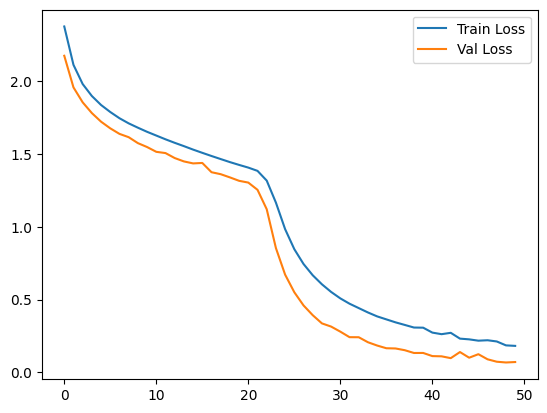

In [104]:
# history += history1
# plt.plot(history)
plt.plot(history1['train'], label='Train Loss')
plt.plot(history1['val'], label='Val Loss')
plt.legend()

In [105]:
# save the model
torch.save(model1.state_dict(), "seq2seq_cipher_transformer.pth")
print("Model saved to seq2seq_cipher_transformer.pth")

Model saved to seq2seq_cipher_transformer.pth


### Load model if already saved

In [45]:
# Use CPU to avoid MPS storage allocation issues
eval_device = torch.device(device)

model1 = Seq2SeqCipherTransformer(vocab_size=vocab_size_1, d_model=256, nhead=8, num_layers=4, d_ff=1024, pad_id=char2idx_1['<PAD>'], max_len=CONTEXT_SIZE)
model1.load_state_dict(torch.load("seq2seq_cipher_transformer.pth", map_location='cpu'))
model1.to(eval_device)
model1.eval()

Seq2SeqCipherTransformer(
  (tok_emb): Embedding(66, 256, padding_idx=0)
  (pos_emb): Embedding(128, 256)
  (offset_emb): Embedding(26, 256)
  (enc_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (dec_layers): ModuleList(
    (0-3): 4 x DecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (cross_attn): MultiheadAtten

In [46]:
print("Device:", device)
print("eval_device:", eval_device)

Device: mps
eval_device: mps


In [47]:
# Quick eval on a few custom samples
def greedy_decode(model, src_ids, char2idx, idx2char, max_len, offset, device):
    model.eval()
    bos_id = char2idx['<BOS>']
    eos_id = char2idx['<EOS>']
    pad_id = char2idx['<PAD>']
    
    src = torch.tensor([src_ids], dtype=torch.long, device=device)
    tgt_ids = [bos_id]
    offset_tensor = torch.tensor([offset], dtype=torch.long, device=device)
    
    with torch.no_grad():
        for _ in range(max_len - 1):
            tgt = torch.tensor([tgt_ids], dtype=torch.long, device=device)
            logits, _ = model(src, tgt, offset_tensor)
            next_id = int(torch.argmax(logits[0, -1]).item())
            tgt_ids.append(next_id)
            if next_id == eos_id:
                break
    
    # strip BOS and everything after EOS/PAD
    out = []
    for tid in tgt_ids[1:]:
        if tid in (eos_id, pad_id):
            break
        out.append(idx2char[tid])
    return ''.join(out)

def eval_samples(model, samples, offset=1):
    results = []
    for s in samples:
        filtered = filter_for_alnum(s).lower()
        ciphered = ''.join([generate_cipher(c, offset) for c in filtered])
        src_ids = [char2idx_1['<BOS>']] + [char2idx_1[c] for c in ciphered][:CONTEXT_SIZE - 2] + [char2idx_1['<EOS>']]
        src_ids += [char2idx_1['<PAD>']] * (CONTEXT_SIZE - len(src_ids))
        pred = greedy_decode(model, src_ids, char2idx_1, idx2char_1, CONTEXT_SIZE, offset, eval_device)
        results.append({
            "raw": s,
            "filtered": filtered,
            "ciphered": ciphered,
            "pred": pred,
        })
    return results

sample_strings = [
    "Transformers can read sequences.",
    "caesar shift with numbers 123 and symbols!",
    "hello world from a tiny eval",
 ]

In [48]:
eval_out = eval_samples(
    model1,  # Using mode1 which is loaded on eval_device (CPU)
    sample_strings,# val_data['filtered_text'].iloc[100:110].tolist(), 
    offset=17
)

for r in eval_out:
    print("RAW     :", r["raw"])
    print("FILTER  :", r["filtered"])
    print("CIPHER  :", r["ciphered"])
    print("PRED    :", r["pred"])
    print("-")

RAW     : Transformers can read sequences.
FILTER  : transformers can read sequences
CIPHER  : kirejwfidvij tre ivru jvhlvetvj
PRED    : transformers can reade squences
-
RAW     : caesar shift with numbers 123 and symbols!
FILTER  : caesar shift with numbers 123 and symbols
CIPHER  : trvjri jyzwk nzky eldsvij 123 reu jpdsfcj
PRED    : casera shift with numbers 123 and symbols
-
RAW     : hello world from a tiny eval
FILTER  : hello world from a tiny eval
CIPHER  : yvccf nficu wifd r kzep vmrc
PRED    : hellow ordl from at in yeval
-


## Confusion Matrix: Offsets vs Input Lengths

In [49]:
# Ensure model is on device and in eval mode
model1.eval()
print(f"Model is on device: {next(model1.parameters()).device}")

Model is on device: mps:0


In [ ]:
# ! pip install seaborn

In [50]:
import numpy as np
import seaborn as sns

### Viz Eval data distribution

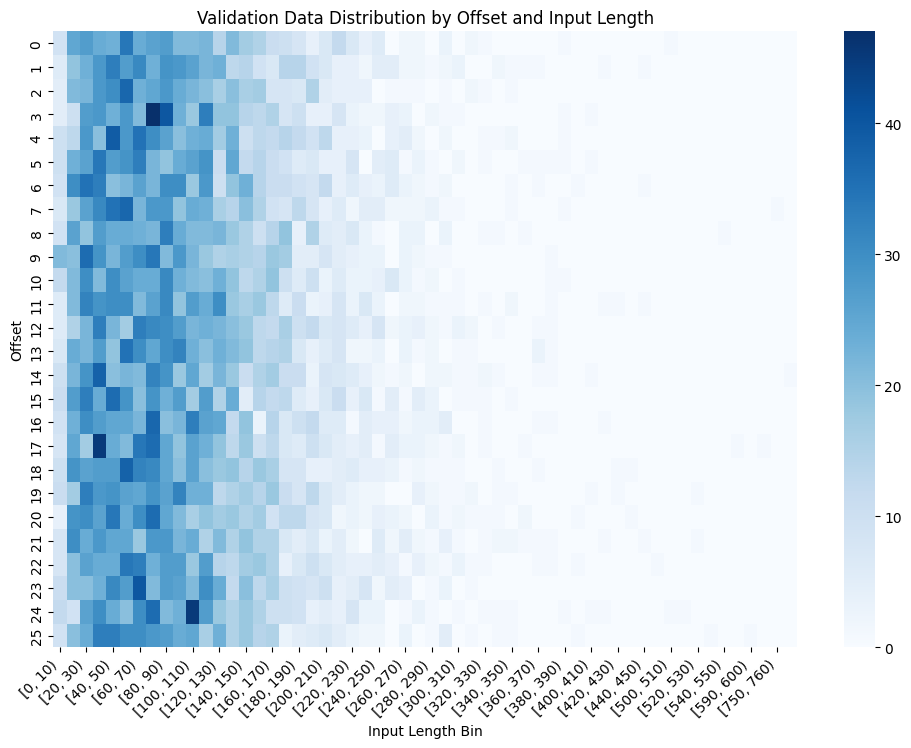

In [51]:
# Visualize eval (validation) data distribution by offset and input length
val_dist = val_data.copy()
val_dist["input_length"] = val_dist["filtered_text"].str.len()

# Bin input lengths to make the heatmap readable
bin_size = 10
max_len = int(val_dist["input_length"].max())
length_bins = list(range(0, max_len + bin_size, bin_size))
val_dist["length_bin"] = pd.cut(val_dist["input_length"], bins=length_bins, right=False)

# Count samples per (offset, length_bin)
count_matrix = (
    val_dist.groupby(["offset", "length_bin"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

plt.figure(figsize=(12, 8))
sns.heatmap(count_matrix, cmap="Blues", annot=False)
plt.xlabel("Input Length Bin")
plt.ylabel("Offset")
plt.title("Validation Data Distribution by Offset and Input Length")
plt.xticks(rotation=45, ha="right")
plt.show()

### Viz Eval Results
Looking at the above data distribution i think we can try to sample all offsets for a input length between 0-128 for sufficient number of samples.

In [52]:
def calculate_fuzzy_score(pred: str, target: str) -> float:
    """
    Calculates a fuzzy accuracy score between prediction and target strings.
    - Removes whitespace from both strings for alignment resilience.
    - For alphabetic characters, awards partial credit based on circular distance in alphabet.
      Score = 1 - (circular_dist / 13)
      e.g. 'a' vs 'b' (dist 1) -> ~0.92, 'a' vs 'z' (dist 1) -> ~0.92, 'a' vs 'n' (dist 13) -> 0.0
    - For non-alphabetic characters (digits), requires exact match.
    - Penalizes length mismatches by dividing by max(len(pred), len(target)).
    """
    # Remove spaces
    pred_clean = pred.replace(" ", "")
    target_clean = target.replace(" ", "")
    
    if not target_clean:
        return 0.0 if pred_clean else 1.0
        
    n = len(target_clean)
    m = len(pred_clean)
    max_len = max(n, m)
    min_len = min(n, m)
    
    total_score = 0.0
    
    for i in range(min_len):
        p_char = pred_clean[i]
        t_char = target_clean[i]
        
        if p_char == t_char:
            total_score += 1.0
        elif p_char.isalpha() and t_char.isalpha():
            # Both letters, check circular distance
            p_code = ord(p_char) - ord('a')
            t_code = ord(t_char) - ord('a')
            
            # Ensure they are in 0-25 range
            if 0 <= p_code <= 25 and 0 <= t_code <= 25:
                diff = abs(p_code - t_code)
                dist = min(diff, 26 - diff)
                total_score += max(0.0, 1.0 - (dist / 13.0))
            else:
                pass
        else:
            # Type mismatch or non-alpha mismatch
            pass
            
    return total_score / max_len if max_len > 0 else 1.0

# Unit Tests for Fuzzy Score
print("Running fuzzy score tests...")
assert calculate_fuzzy_score("hello", "hello") == 1.0, "Exact match failed"
assert calculate_fuzzy_score("hello world", "helloworld") == 1.0, "Space ignore failed"
assert abs(calculate_fuzzy_score("abc", "abd") - (1 + 1 + (1 - 1/13)) / 3) < 1e-6, "Char distance 1 failed"
assert abs(calculate_fuzzy_score("a", "z") - (1 - 1/13)) < 1e-6, "Wrap around distance 1 failed"
assert calculate_fuzzy_score("a", "n") == 0.0, "Max distance failed"
assert calculate_fuzzy_score("123", "124") == 2/3, "Digit mismatch failed"
print("All tests passed!")

Running fuzzy score tests...
All tests passed!


In [53]:
# Generate some sample scores to see how the fuzzy score behaves on our eval samples
for r in eval_out:
    score = calculate_fuzzy_score(r["pred"], r["filtered"])
    print(f"Pred: {r['pred']} | Target: {r['filtered']} | Fuzzy Score: {score:.4f}")

Pred: transformers can reade squences | Target: transformers can read sequences | Fuzzy Score: 0.9341
Pred: casera shift with numbers 123 and symbols | Target: caesar shift with numbers 123 and symbols | Fuzzy Score: 0.9077
Pred: hellow ordl from at in yeval | Target: hello world from a tiny eval | Fuzzy Score: 0.9465


In [54]:
# Use tqdm for progress
from tqdm import tqdm

Original Eval Size: 8112
Balanced Subset Size: 1689 (approx 5 samples per offset/len_bin)
Starting evaluation...


Offset 25 | Length Bin 120 | Acc 0.9040: 100%|██████████| 338/338 [06:48<00:00,  1.21s/it]


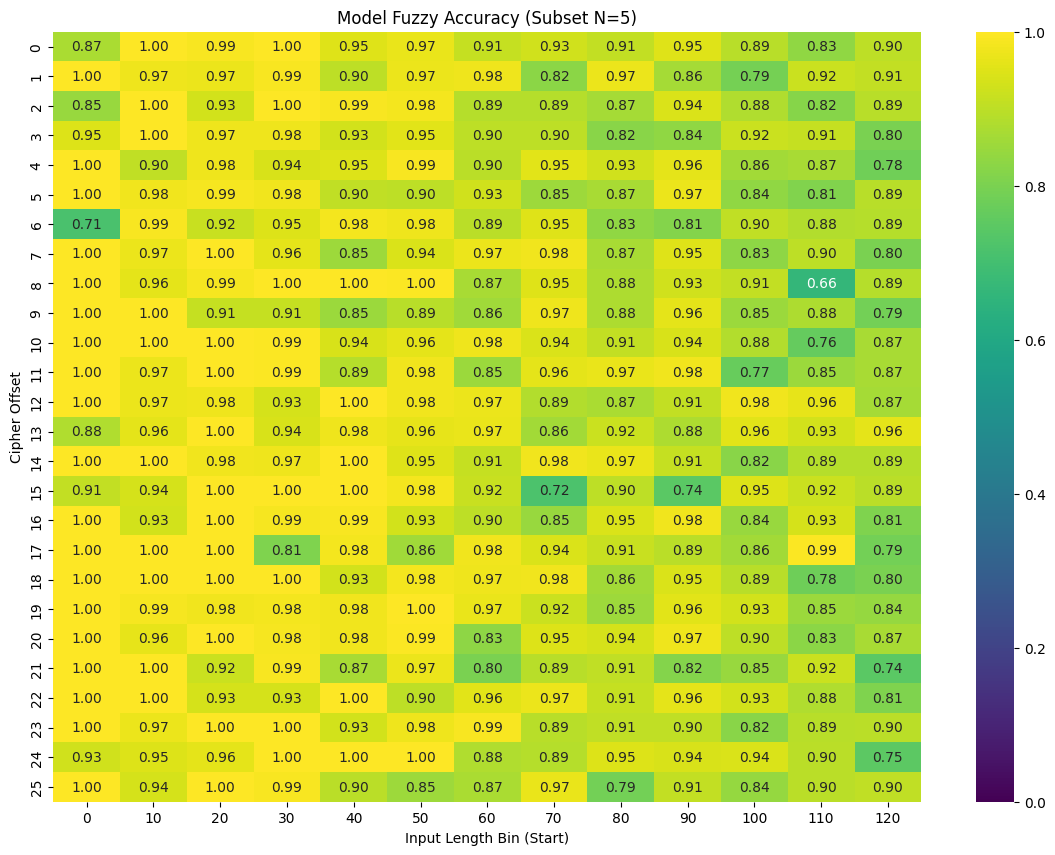

In [56]:
# Configuration for Quick Balanced Evaluation
SAMPLES_PER_GROUP = 5   # Kept small for quick assessment
MAX_EVAL_LEN = 128      # Limit sequence length
BIN_SIZE = 10           # Bucket size for length

# 1. Prepare Data with Bins
# Ensure we work with a clean dataframe with standard index and 'offset' as a column
eval_df = val_data[val_data['filtered_text'].str.len() <= MAX_EVAL_LEN].copy()
if 'offset' not in eval_df.columns:
    eval_df = eval_df.reset_index() # Bring offset back if it was in index

eval_df = eval_df.reset_index(drop=True) # Flatten index
eval_df['length_bin'] = (eval_df['filtered_text'].str.len() // BIN_SIZE) * BIN_SIZE

# 2. Create Stratified Subset
# We want up to N samples for every combination of (offset, length_bin)
def create_stratified_subset(df, n_samples):
    subset = (
        df.groupby(['offset', 'length_bin'], group_keys=True)
          .apply(lambda x: x.sample(n=min(len(x), n_samples), random_state=42))
          .reset_index(level=[0, 1])
    )
    return subset

balanced_subset = create_stratified_subset(eval_df, SAMPLES_PER_GROUP)
print(f"Original Eval Size: {len(eval_df)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (approx {SAMPLES_PER_GROUP} samples per offset/len_bin)")

# 3. Running Evaluation on Subset
results_matrix = {
    'offset': [],
    'length_bin': [],
    'accuracy': []
}

model1 = model1.to(device)
model1.eval()

# Using robust iteration instead of groupby to avoid potential KeyErrors
unique_offsets = sorted(balanced_subset['offset'].unique())
unique_bins = sorted(balanced_subset['length_bin'].unique())
total_steps = len(unique_offsets) * len(unique_bins)

from tqdm import tqdm
print("Starting evaluation...")

with tqdm(total=total_steps) as pbar:
    for offset in unique_offsets:
        for l_bin in unique_bins:
            # Filter the subset
            group_df = balanced_subset[
                (balanced_subset['offset'] == offset) & 
                (balanced_subset['length_bin'] == l_bin)
            ]
            
            if len(group_df) == 0:
                pbar.update(1)
                continue

            batch_scores = []
            for _, row in group_df.iterrows():
                ciphered = row['ciphered_text']
                target = row['filtered_text']
                
                # Prepare input
                ids = [char2idx_1['<BOS>']] + [char2idx_1[c] for c in ciphered][:CONTEXT_SIZE - 2] + [char2idx_1['<EOS>']]
                ids += [char2idx_1['<PAD>']] * (CONTEXT_SIZE - len(ids))
                
                # Decode
                pred = greedy_decode(model1, ids, char2idx_1, idx2char_1, CONTEXT_SIZE, offset, device)
                
                # Score
                score = calculate_fuzzy_score(pred, target)
                batch_scores.append(score)
            
            # Record average accuracy for this bin
            avg_score = sum(batch_scores) / len(batch_scores)
            results_matrix['offset'].append(offset)
            results_matrix['length_bin'].append(l_bin)
            results_matrix['accuracy'].append(avg_score)
            pbar.set_description(f"Offset {offset} | Length Bin {l_bin} | Acc {avg_score:.4f}")
            pbar.update(1)

# 4. Visualization
res_df = pd.DataFrame(results_matrix)
heatmap_data = res_df.pivot(index='offset', columns='length_bin', values='accuracy')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title(f"Model Fuzzy Accuracy (Subset N={SAMPLES_PER_GROUP})")
plt.xlabel("Input Length Bin (Start)")
plt.ylabel("Cipher Offset")
plt.show()

## Lets visualize the attention maps

Visualizing attention for sample with offset=22


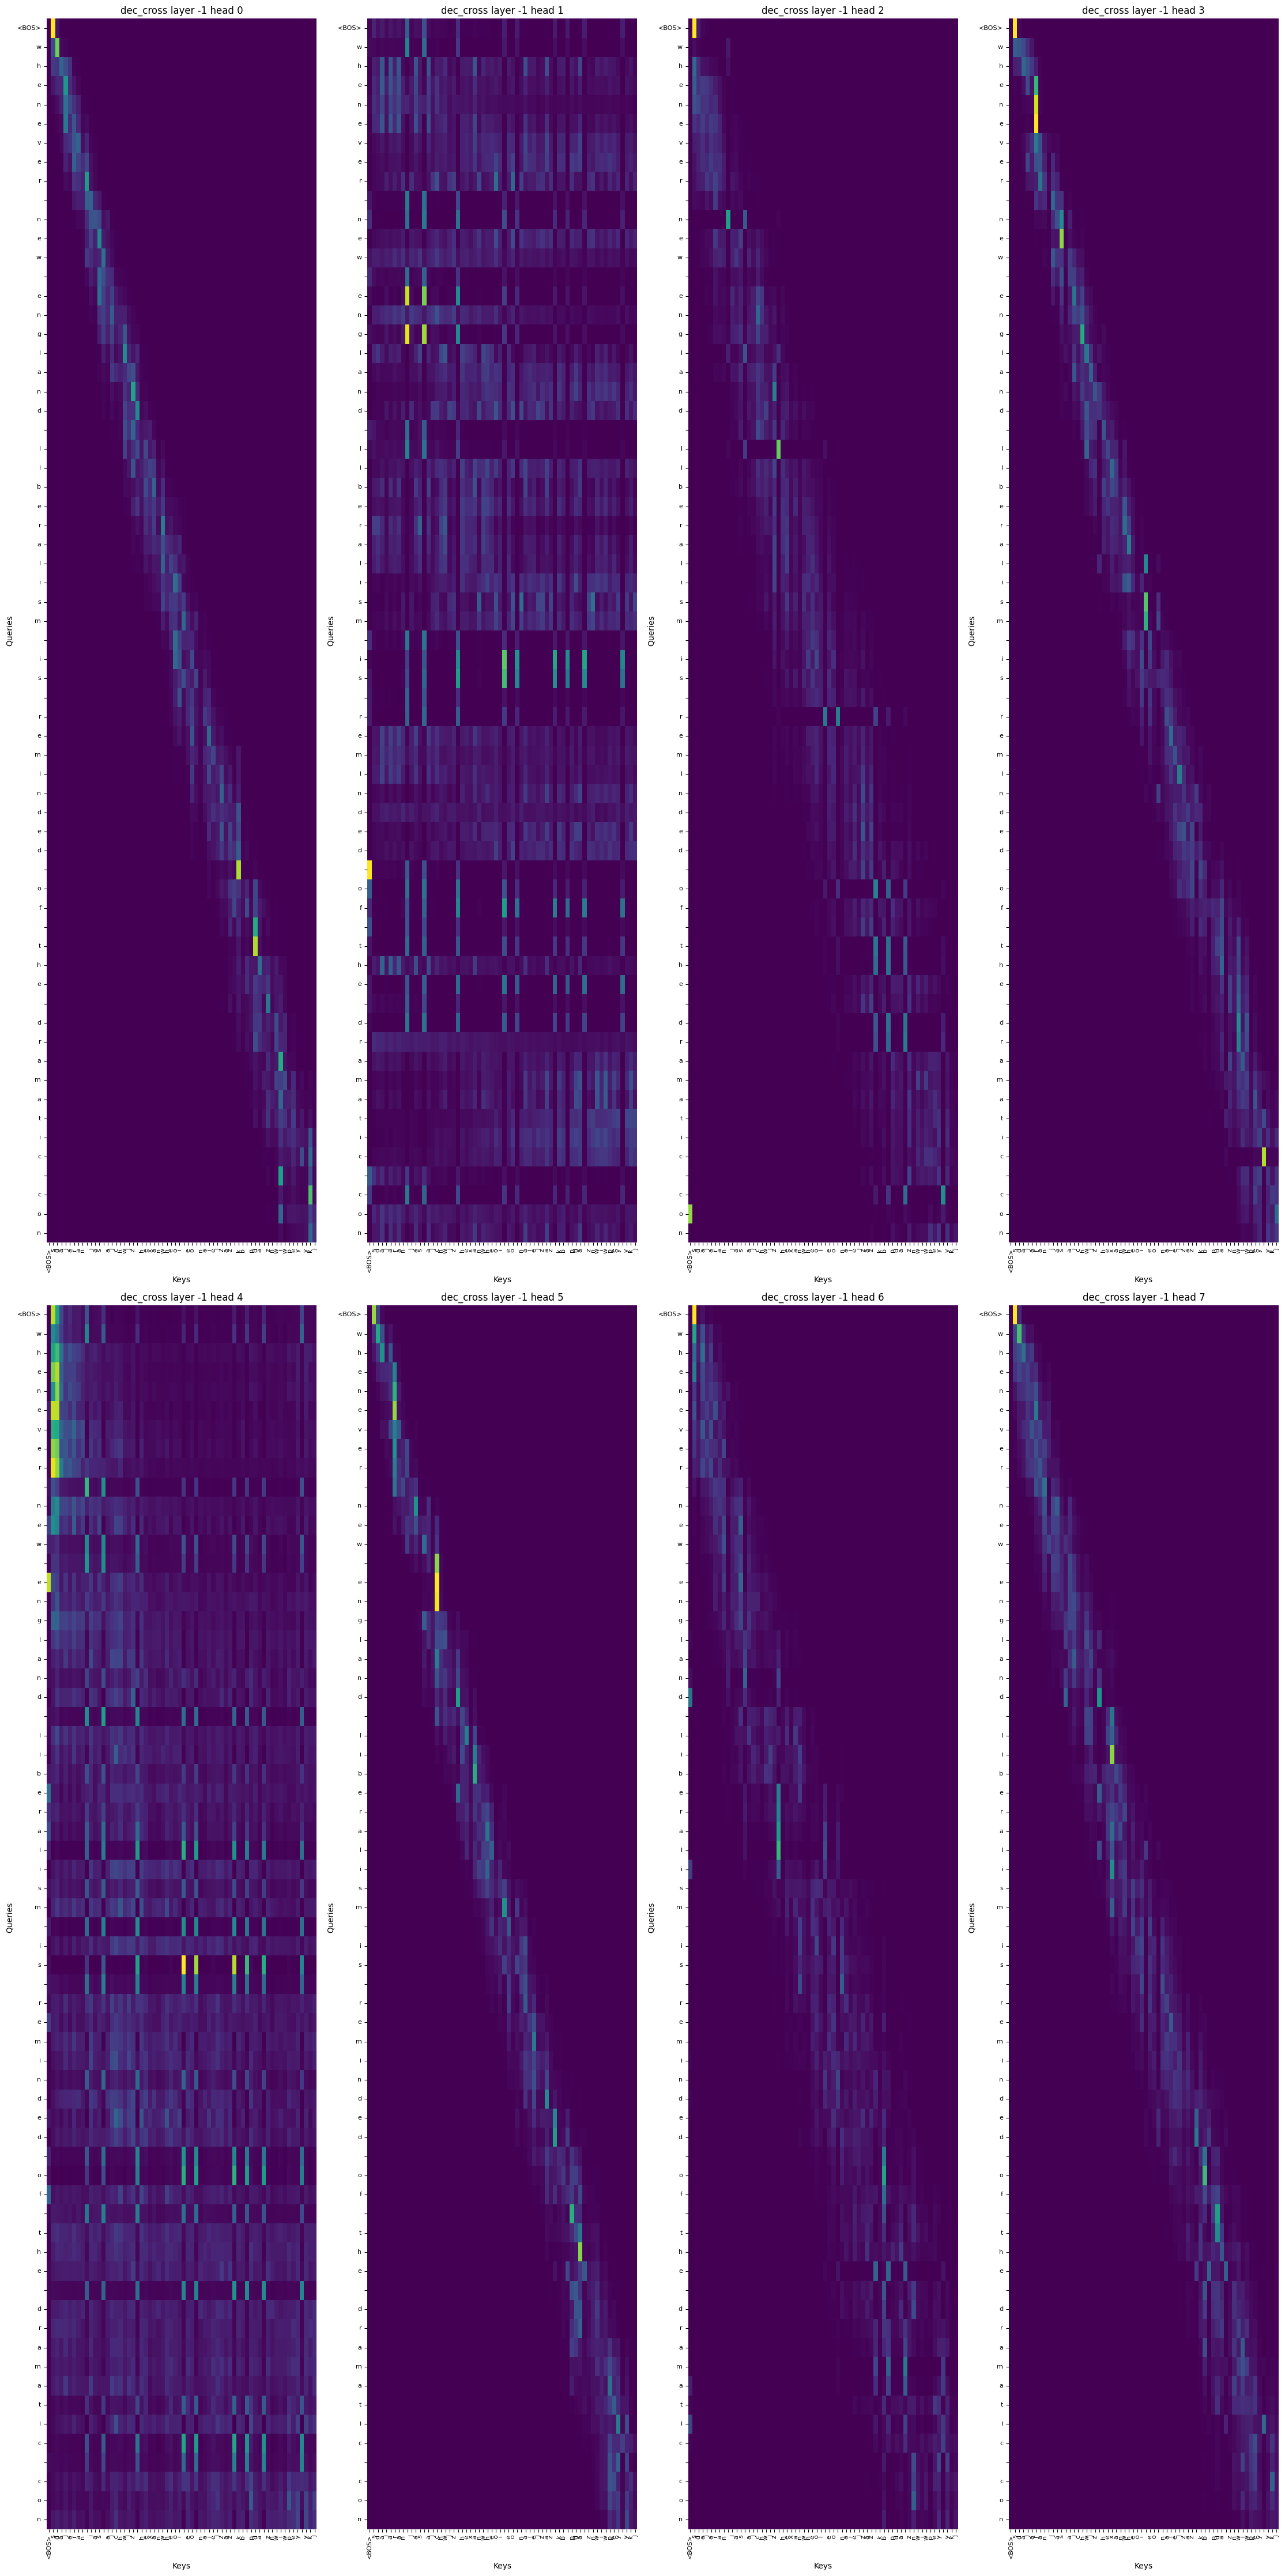

In [69]:
# Visualize a cross-attention map for a single sample
viz = AttnVizUtils(VOCAB_1)

row = clean_data.iloc[9]
ciphered = row["ciphered_text"]
filtered = row["filtered_text"]
offset = row["offset"]
print(f"Visualizing attention for sample with offset={offset}")
src_ids = viz.encode_text(ciphered, add_bos=True, add_eos=True)[:CONTEXT_SIZE]
src_ids += [char2idx_1["<PAD>"]] * (CONTEXT_SIZE - len(src_ids))

tgt_ids = viz.encode_text(filtered, add_bos=True, add_eos=True)[:CONTEXT_SIZE]
tgt_ids += [char2idx_1["<PAD>"]] * (CONTEXT_SIZE - len(tgt_ids))

model1.eval()
with torch.no_grad():
    _, attn = model1(
        torch.tensor([src_ids], device=device),
        torch.tensor([tgt_ids], device=device),
        torch.tensor([offset], dtype=torch.long, device=device),
        return_attn=True,
    )
    # Plot each head in a grid layout
    kind = "dec_cross"
    layer = -1
    max_tokens = 64

    w = attn[kind][layer].detach().cpu()[0]  # [H, Ttgt, Tsrc]

    x_tokens = viz.ids_to_tokens(src_ids, max_tokens=max_tokens)
    y_tokens = viz.ids_to_tokens(tgt_ids, max_tokens=max_tokens)

    num_heads = w.shape[0]
    ncols = 4
    nrows = int(np.ceil(num_heads / ncols))

    fig_w = max(16, len(x_tokens) * 0.35)
    fig_h = max(6, len(y_tokens) * 0.35) * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)

    for h in range(num_heads):
        r, c = divmod(h, ncols)
        ax = axes[r][c]
        w_h = w[h][:len(y_tokens), :len(x_tokens)]

        sns.heatmap(
            w_h,
            cmap="viridis",
            xticklabels=x_tokens,
            yticklabels=y_tokens,
            cbar=False,
            ax=ax,
        )
        ax.set_title(f"{kind} layer {layer} head {h}")
        ax.set_xlabel("Keys")
        ax.set_ylabel("Queries")
        ax.tick_params(axis="x", labelrotation=90, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

    # Hide unused subplots
    for idx in range(num_heads, nrows * ncols):
        r, c = divmod(idx, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()


## Thoughts on Reading Attention

We can clearly see a bunch of attention heads having diagonal shapes (heads 0,3,5,7), indicating that the model has surely learnt the positional encoding where its recognized that it needs to look at the tokens at the corresponding positions between input and output. 


We also see some a bunch of scattered and grid like heads like heads 1 and 4, I'm not exactly sure how to interpret this other than they are encoding the offset somehow or providing enough offset representation to the FNN to compute and output the correct offset. And we can try to visulize these heads for different offsets and see when/where they activate below. But it's not obvious what these grid like attention's do, but it is valuable to keep in mind that cross-attention is routing information `Q -> (K,V)`, so its also perfectly possible that these are the best intermediate routing rules/representations for the final FFN to correctly predict the de-ciphered text.

Ideally to continue along the Mechanistic Interpretability path we will have to perform a few more hypothesis, ablation and interventions to gain concrete evidence and causality which is beyond scope of what I set out to do in this note book :)


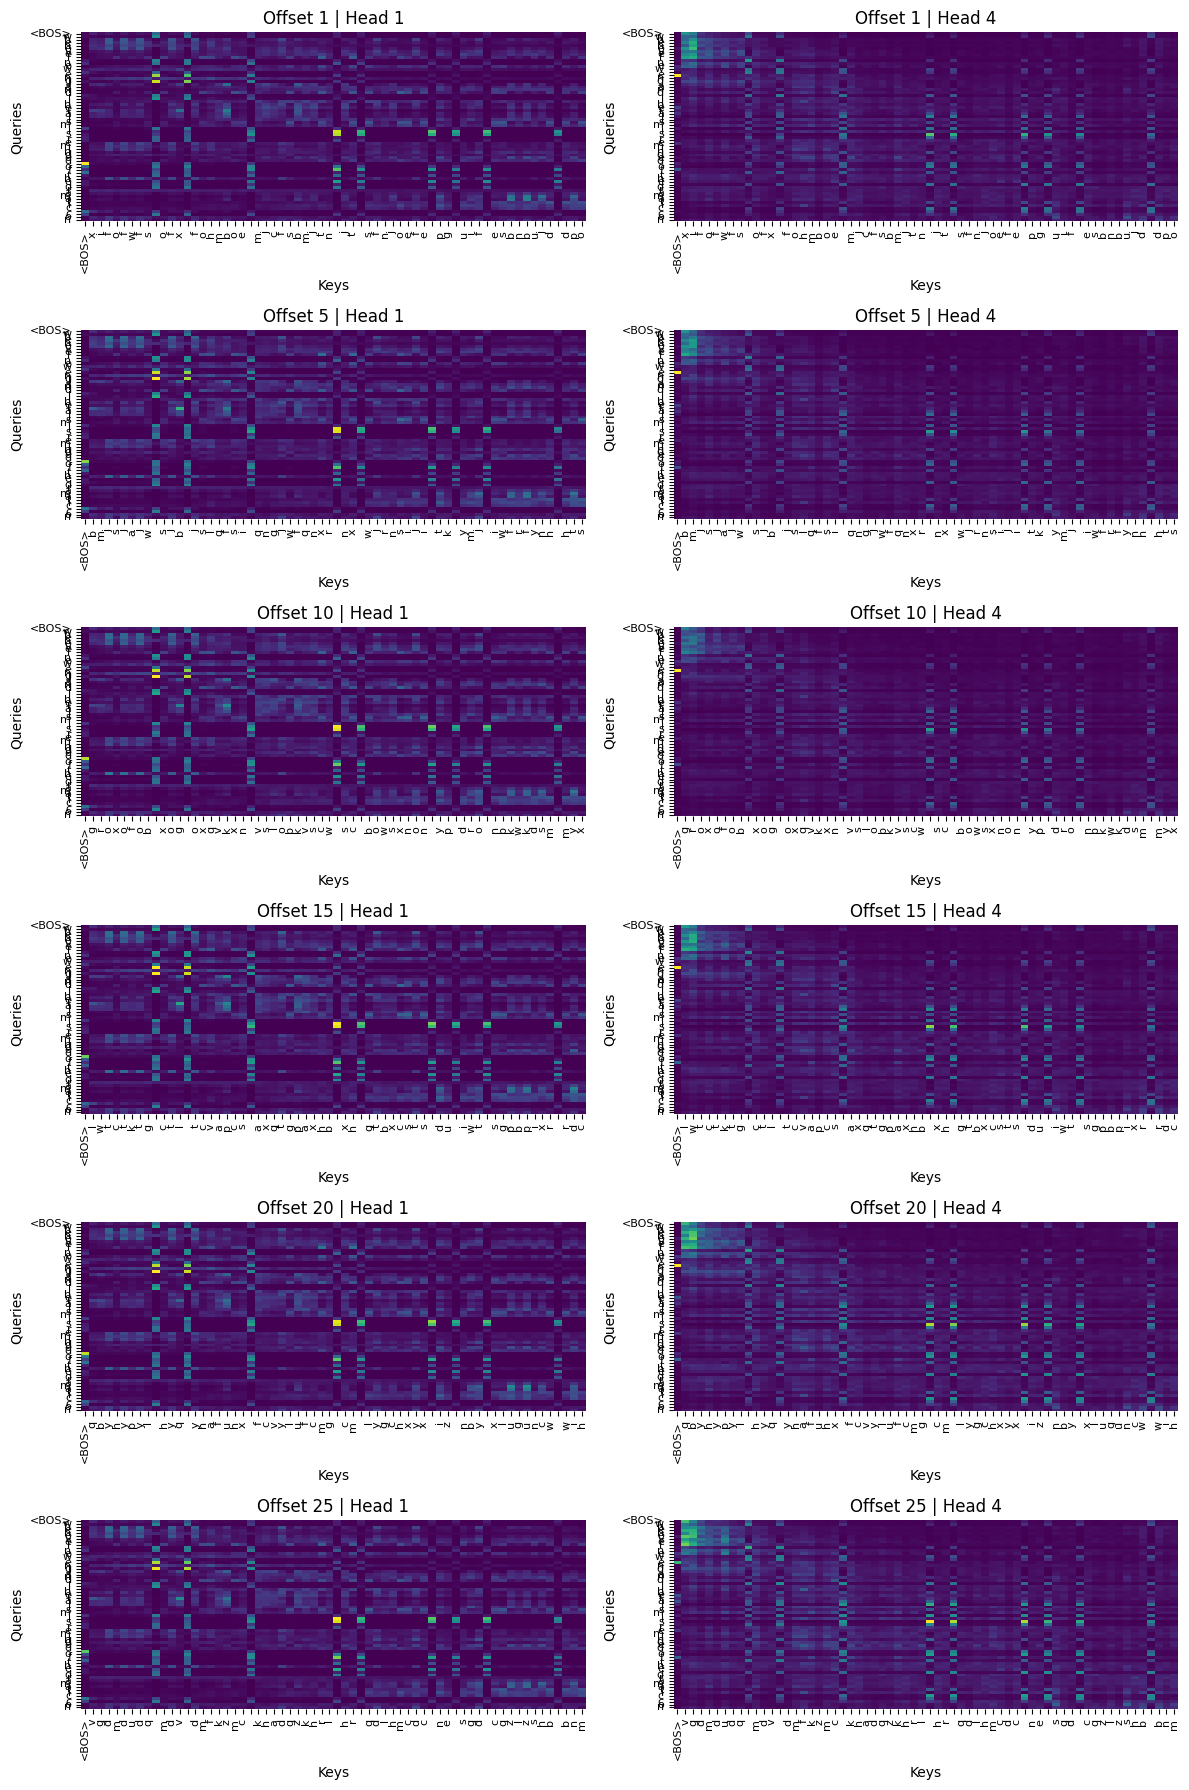

In [76]:
# Plot cross-attention maps for decoder heads 1 and 4 across multiple offsets
offsets = [1, 5, 10, 15, 20, 25]
head_ids = [1, 4]
layer = -1
max_tokens = 64

# Use a fixed sample (filtered text) and recipher with different offsets
sample_row = clean_data.iloc[9]
filtered_text = sample_row["filtered_text"]

tgt_ids = viz.encode_text(filtered_text, add_bos=True, add_eos=True)[:CONTEXT_SIZE]
tgt_ids += [char2idx_1["<PAD>"]] * (CONTEXT_SIZE - len(tgt_ids))

fig, axes = plt.subplots(len(offsets), len(head_ids), figsize=(12, 3 * len(offsets)), squeeze=False)

model1.eval()
with torch.no_grad():
    for r, offset in enumerate(offsets):
        ciphered = "".join(generate_cipher(c, offset) for c in filtered_text)
        src_ids = viz.encode_text(ciphered, add_bos=True, add_eos=True)[:CONTEXT_SIZE]
        src_ids += [char2idx_1["<PAD>"]] * (CONTEXT_SIZE - len(src_ids))

        _, attn = model1(
            torch.tensor([src_ids], device=device),
            torch.tensor([tgt_ids], device=device),
            torch.tensor([offset], dtype=torch.long, device=device),
            return_attn=True,
        )

        w = attn["dec_cross"][layer].detach().cpu()[0]  # [H, Ttgt, Tsrc]
        x_tokens = viz.ids_to_tokens(src_ids, max_tokens=max_tokens)
        y_tokens = viz.ids_to_tokens(tgt_ids, max_tokens=max_tokens)

        for c, head in enumerate(head_ids):
            ax = axes[r][c]
            w_h = w[head][:len(y_tokens), :len(x_tokens)]
            sns.heatmap(
                w_h,
                cmap="viridis",
                xticklabels=x_tokens,
                yticklabels=y_tokens,
                cbar=False,
                ax=ax,
            )
            ax.set_title(f"Offset {offset} | Head {head}")
            ax.set_xlabel("Keys")
            ax.set_ylabel("Queries")
            ax.tick_params(axis="x", labelrotation=90, labelsize=8)
            ax.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()
